In [54]:
import copy

import numpy as np
import nnfs
import pickle
import copy
from nnfs.datasets import spiral_data

nnfs.init()


# Dense layer
class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons,
                 weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        # Set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    # Forward pass
    def forward(self, inputs, training):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)


        # Gradients on regularization
        # L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        # L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * \
                             self.weights
        # L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        # L2 on biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * \
                            self.biases

        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

    def get_parameters(self):
        return self.weights, self.biases

    def set_parameters(self, weights, biases):
        self.weights = weights
        self.biases = biases




# Dropout
class Layer_Dropout:

    # Init
    def __init__(self, rate):
        # Store rate, we invert it as for example for dropout
        # of 0.1 we need success rate of 0.9
        self.rate = 1 - rate

    # Forward pass
    def forward(self, inputs, training):
        # Save input values
        self.inputs = inputs

        # If not in the training mode - return values
        if not training:
            self.output = inputs.copy()
            return

        # Generate and save scaled mask
        self.binary_mask = np.random.binomial(1, self.rate,
                           size=inputs.shape) / self.rate
        # Apply mask to output values
        self.output = inputs * self.binary_mask


    # Backward pass
    def backward(self, dvalues):
        # Gradient on values
        self.dinputs = dvalues * self.binary_mask


# Input "layer"
class Layer_Input:

    # Forward pass
    def forward(self, inputs, training):
        self.output = inputs


# ReLU activation
class Activation_ReLU:

    # Forward pass
    def forward(self, inputs, training):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

    # Calculate predictions for outputs
    def predictions(self, outputs):
        return outputs


# Softmax activation
class Activation_Softmax:

    # Forward pass
    def forward(self, inputs, training):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))

        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):

        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
                                         single_dvalues)

    # Calculate predictions for outputs
    def predictions(self, outputs):
        return np.argmax(outputs, axis=1)


# Sigmoid activation
class Activation_Sigmoid:

    # Forward pass
    def forward(self, inputs, training):
        # Save input and calculate/save output
        # of the sigmoid function
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    # Backward pass
    def backward(self, dvalues):
        # Derivative - calculates from output of the sigmoid function
        self.dinputs = dvalues * (1 - self.output) * self.output

    # Calculate predictions for outputs
    def predictions(self, outputs):
        return (outputs > 0.5) * 1


# Linear activation
class Activation_Linear:

    # Forward pass
    def forward(self, inputs, training):
        # Just remember values
        self.inputs = inputs
        self.output = inputs

    # Backward pass
    def backward(self, dvalues):
        # derivative is 1, 1 * dvalues = dvalues - the chain rule
        self.dinputs = dvalues.copy()

    # Calculate predictions for outputs
    def predictions(self, outputs):
        return outputs


# SGD optimizer
class Optimizer_SGD:

    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If we use momentum
        if self.momentum:

            # If layer does not contain momentum arrays, create them
            # filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                # If there is no momentum array for weights
                # The array doesn't exist for biases yet either.
                layer.bias_momentums = np.zeros_like(layer.biases)
            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with
            # current gradients
            weight_updates = \
                self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            # Build bias updates
            bias_updates = \
                self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * \
                             layer.dweights
            bias_updates = -self.current_learning_rate * \
                           layer.dbiases

        # Update weights and biases using either
        # vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Adagrad optimizer
class Optimizer_Adagrad:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))


    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# RMSprop optimizer
class Optimizer_RMSprop:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))


    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache = self.rho * layer.weight_cache + \
            (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + \
            (1 - self.rho) * layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Adam optimizer
class Optimizer_Adam:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))


    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum  with current gradients
        layer.weight_momentums = self.beta_1 * \
                                 layer.weight_momentums + \
                                 (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * \
                               layer.bias_momentums + \
                               (1 - self.beta_1) * layer.dbiases
        # Get corrected momentum
        # self.iteration is 0 at first pass
        # and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
            (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + \
            (1 - self.beta_2) * layer.dbiases**2
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         weight_momentums_corrected / \
                         (np.sqrt(weight_cache_corrected) +
                             self.epsilon)
        layer.biases += -self.current_learning_rate * \
                         bias_momentums_corrected / \
                         (np.sqrt(bias_cache_corrected) +
                             self.epsilon)


    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Common loss class
class Loss:

    # Regularization loss calculation
    def regularization_loss(self):

        # 0 by default
        regularization_loss = 0

        # Calculate regularization loss
        # iterate all trainable layers
        for layer in self.trainable_layers:

            # L1 regularization - weights
            # calculate only when factor greater than 0
            if layer.weight_regularizer_l1 > 0:
                regularization_loss += layer.weight_regularizer_l1 * \
                                       np.sum(np.abs(layer.weights))

            # L2 regularization - weights
            if layer.weight_regularizer_l2 > 0:
                regularization_loss += layer.weight_regularizer_l2 * \
                                       np.sum(layer.weights *
                                              layer.weights)

            # L1 regularization - biases
            # calculate only when factor greater than 0
            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * \
                                       np.sum(np.abs(layer.biases))

            # L2 regularization - biases
            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * \
                                       np.sum(layer.biases *
                                              layer.biases)

        return regularization_loss

    # Set/remember trainable layers
    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers


    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y, *, include_regularization=False):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        self.accumulated_sum += np.sum(sample_losses)
        self.accumulated_count += len(sample_losses)

        # If just data loss - return it
        if not include_regularization:
            return data_loss

        # Return the data and regularization losses
        return data_loss, self.regularization_loss()

    def calculate_accumulated(self, *, include_regularization=False):
        data_loss = self.accumulated_sum/self.accumulated_count
        if not include_regularization:
            return data_loss
        return data_loss, self.regularization_loss()

    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0



# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)

        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples



# Binary cross-entropy loss
class Loss_BinaryCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Calculate sample-wise loss
        sample_losses = -(y_true * np.log(y_pred_clipped) +
                          (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)

        # Calculate gradient
        self.dinputs = -(y_true / clipped_dvalues -
                         (1 - y_true) / (1 - clipped_dvalues)) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Mean Squared Error loss
class Loss_MeanSquaredError(Loss):  # L2 loss

    # Forward pass
    def forward(self, y_pred, y_true):

        # Calculate loss
        sample_losses = np.mean((y_true - y_pred)**2, axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Gradient on values
        self.dinputs = -2 * (y_true - dvalues) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Mean Absolute Error loss
class Loss_MeanAbsoluteError(Loss):  # L1 loss

    def forward(self, y_pred, y_true):

        # Calculate loss
        sample_losses = np.mean(np.abs(y_true - y_pred), axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Calculate gradient
        self.dinputs = np.sign(y_true - dvalues) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples



# Common accuracy class
class Accuracy:

    # Calculates an accuracy
    # given predictions and ground truth values
    def calculate(self, predictions, y):

        # Get comparison results
        comparisons = self.compare(predictions, y)

        # Calculate an accuracy
        accuracy = np.mean(comparisons)


        self.accumulated_sum += np.sum(comparisons)
        self.accumulated_count += len(comparisons)


        # Return accuracy
        return accuracy

    def calculate_accumulated(self):
        accuracy = self.accumulated_sum/self.accumulated_count
        return accuracy

    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0




# Accuracy calculation for classification model
class Accuracy_Categorical(Accuracy):

    def __init__(self, *, binary=False):
        # Binary mode?
        self.binary = binary

    # No initialization is needed
    def init(self, y):
        pass

    # Compares predictions to the ground truth values
    def compare(self, predictions, y):
        if not self.binary and len(y.shape) == 2:
            y = np.argmax(y, axis=1)
        return predictions == y


# Accuracy calculation for regression model
class Accuracy_Regression(Accuracy):

    def __init__(self):
        # Create precision property
        self.precision = None

    # Calculates precision value
    # based on passed-in ground truth values
    def init(self, y, reinit=False):
        if self.precision is None or reinit:
            self.precision = np.std(y) / 250


    # Compares predictions to the ground truth values
    def compare(self, predictions, y):
        return np.absolute(predictions - y) < self.precision


# Model class
class Model:

    def __init__(self):
        # Create a list of network objects
        self.layers = []
        # Softmax classifier's output object
        self.softmax_classifier_output = None

    # Add objects to the model
    def add(self, layer):
        self.layers.append(layer)

    # Set loss, optimizer and accuracy
    def set(self, *, loss, optimizer, accuracy):
        if loss is not None:
            self.loss = loss
        if optimizer is not None:
            self.optimizer = optimizer
        if accuracy is not None:
            self.accuracy = accuracy

    # Finalize the model
    def finalize(self):

        # Create and set the input layer
        self.input_layer = Layer_Input()

        # Count all the objects
        layer_count = len(self.layers)

        # Initialize a list containing trainable layers:
        self.trainable_layers = []

        # Iterate the objects
        for i in range(layer_count):

            # If it's the first layer,
            # the previous layer object is the input layer
            if i == 0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i+1]

            # All layers except for the first and the last
            elif i < layer_count - 1:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.layers[i+1]

            # The last layer - the next object is the loss
            # Also let's save aside the reference to the last object
            # whose output is the model's output
            else:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.loss
                self.output_layer_activation = self.layers[i]

            # If layer contains an attribute called "weights",
            # it's a trainable layer -
            # add it to the list of trainable layers
            # We don't need to check for biases -
            # checking for weights is enough
            if hasattr(self.layers[i], 'weights'):
                self.trainable_layers.append(self.layers[i])

        # Update loss object with trainable layers
        if self.loss is not None:
            self.loss.remember_trainable_layers(
                self.trainable_layers
            )

        # If output activation is Softmax and
        # loss function is Categorical Cross-Entropy
        # create an object of combined activation
        # and loss function containing
        # faster gradient calculation
        if isinstance(self.layers[-1], Activation_Softmax) and \
           isinstance(self.loss, Loss_CategoricalCrossentropy):
            # Create an object of combined activation
            # and loss functions
            self.softmax_classifier_output = \
                Activation_Softmax_Loss_CategoricalCrossentropy()

    # Train the model
    def train(self, X, y, *, epochs=1, batch_size=None, print_every=1,
              validation_data=None):

        # Initialize accuracy object
        self.accuracy.init(y)

        train_steps = 1

        if validation_data is not None:
            validation_steps  = 1
            X_val, y_val = validation_data

        if batch_size is not None:
            train_steps = len(X)//batch_size
            if train_steps*batch_size < len(X):
                train_steps+=1
            if validation_data is not None:
                validation_steps = len(X_val)//batch_size
                if validation_steps*batch_size < len(X_val):
                    validation_steps+=1

        # Main training loop
        for epoch in range(1, epochs+1):

            print(f'epoch: {epoch}')
            self.loss.new_pass()
            self.accuracy.new_pass()

            for step in range(train_steps):
                if batch_size is None:
                    batch_X = X
                    batch_y = y
                else:
                    batch_X = X[step*batch_size:(step+1)*batch_size]
                    batch_y = y[step*batch_size:(step+1)*batch_size]

                # Perform the forward pass
                output = self.forward(batch_X, training=True)


                # Calculate loss
                data_loss, regularization_loss = self.loss.calculate(output, batch_y, include_regularization=True)
                loss = data_loss + regularization_loss

                # Get predictions and calculate an accuracy
                predictions = self.output_layer_activation.predictions(output)
                accuracy = self.accuracy.calculate(predictions, batch_y)

                # Perform backward pass
                self.backward(output, batch_y)

                # Optimize (update parameters)
                self.optimizer.pre_update_params()
                for layer in self.trainable_layers:
                    self.optimizer.update_params(layer)
                self.optimizer.post_update_params()

                # Print a summary
                if not step % print_every or step == train_steps -1:
                    print(f'step: {step}, ' +
                      f'acc: {accuracy:.3f}, ' +
                      f'loss: {loss:.3f} (' +
                      f'data_loss: {data_loss:.3f}, ' +
                      f'reg_loss: {regularization_loss:.3f}), ' +
                      f'lr: {self.optimizer.current_learning_rate}')

            epoch_data_loss,epoch_regularization_loss = \
                self.loss.calculate_accumulated(
                    include_regularization=True)
            epoch_loss = epoch_data_loss+epoch_regularization_loss
            epoch_accuracy = self.accuracy.calculate_accumulated()
            print(f'training, ' +
                      f'acc: {epoch_accuracy:.3f}, ' +
                      f'loss: {epoch_loss:.3f} (' +
                      f'data_loss: {epoch_data_loss:.3f}, ' +
                      f'reg_loss: {epoch_regularization_loss:.3f}), ' +
                      f'lr: {self.optimizer.current_learning_rate}')
            if validation_data is not None:
                self.evaluate(*validation_data, batch_size=batch_size)



    # Performs forward pass
    def forward(self, X, training):

        # Call forward method on the input layer
        # this will set the output property that
        # the first layer in "prev" object is expecting
        self.input_layer.forward(X, training)

        # Call forward method of every object in a chain
        # Pass output of the previous object as a parameter
        for layer in self.layers:
            layer.forward(layer.prev.output, training)

        # "layer" is now the last object from the list,
        # return its output
        return layer.output

    # Performs backward pass
    def backward(self, output, y):

        # If softmax classifier
        if self.softmax_classifier_output is not None:
            # First call backward method
            # on the combined activation/loss
            # this will set dinputs property
            self.softmax_classifier_output.backward(output, y)

            # Since we'll not call backward method of the last layer
            # which is Softmax activation
            # as we used combined activation/loss
            # object, let's set dinputs in this object
            self.layers[-1].dinputs = \
                self.softmax_classifier_output.dinputs

            # Call backward method going through
            # all the objects but last
            # in reversed order passing dinputs as a parameter
            for layer in reversed(self.layers[:-1]):
                layer.backward(layer.next.dinputs)

            return


        # First call backward method on the loss
        # this will set dinputs property that the last
        # layer will try to access shortly
        self.loss.backward(output, y)

        # Call backward method going through all the objects
        # in reversed order passing dinputs as a parameter
        for layer in reversed(self.layers):
            layer.backward(layer.next.dinputs)

    def evaluate(self, X_val, y_val, *, batch_size=None):
        validation_steps = 1
        if batch_size is not None:
            validation_steps = len(X_val)//batch_size
            if validation_steps*batch_size<len(X_val):
                validation_steps+=1
        self.loss.new_pass()
        self.accuracy.new_pass()

        for step in range(validation_steps):
            if batch_size is None:
                batch_X = X_val
                batch_y = y_val
            else:
                batch_X = X_val[step*batch_size: (step+1)*batch_size]
                batch_y = y_val[step*batch_size: (step+1)*batch_size]
                # Perform the forward pass
            output = self.forward(batch_X, training=False)

                # Calculate the loss
            loss = self.loss.calculate(output, batch_y)

                    # Get predictions and calculate an accuracy
            predictions = self.output_layer_activation.predictions(
                              output)
            self.accuracy.calculate(predictions, batch_y)

        validation_loss = self.loss.calculate_accumulated()
        validation_accuracy = self.accuracy.calculate_accumulated()
                # Print a summary
        print(f'validation, ' +
          f'acc: {validation_accuracy:.3f}, ' +
          f'loss: {validation_loss:.3f}')

    def get_parameters(self):
        parameters = []
        for layer in self.trainable_layers:
            parameters.append(layer.get_parameters())
        return parameters

    def set_parameters(self, parameters):
        for parameter_set, layer in zip(parameters, self.trainable_layers):
            layer.set_parameters(*parameter_set)

    def save_parameters(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self.get_parameters(), f)

    def load_parameters(self, path):
        with open(path, 'rb') as f:
            self.set_parameters(pickle.load(f))
    def save(self, path):
        model = copy.deepcopy(self)
        model.loss.new_pass()
        model.accuracy.new_pass()
        model.input_layer.__dict__.pop('output', None)
        model.loss.__dict__.pop('dinputs', None)

        for layer in model.layers:
            for property in ['inputs', 'output', 'dinputs', 'dweights', 'dbiases']:
                layer.__dict__.pop(property, None)
        with open(path, 'wb') as f:
            pickle.dump(model, f)

    @staticmethod
    def load(path):
        with open(path, 'rb') as f:
            model = pickle.load(f)

        return model

    def predict(self, X, *, batch_size=None):
        prediction_steps = 1
        if batch_size is not None:
            prediction_steps = len(X)// batch_size
            if prediction_steps * batch_size< len(X):
                prediction_steps+=1

        output = []
        for step in range(prediction_steps):
            if batch_size is None:
                batch_X = X
            else:
                batch_X = X[step*batch_size:(step+1)*batch_size]
            batch_output = self.forward(batch_X, training=False)
            output.append(batch_output)
            return np.vstack(output)


# # Create dataset
# X, y = spiral_data(samples=1000, classes=3)
# X_test, y_test = spiral_data(samples=100, classes=3)
#
# # Instantiate the model
# model = Model()
#
# # Add layers
# model.add(Layer_Dense(2, 512, weight_regularizer_l2=5e-4,
#                               bias_regularizer_l2=5e-4))
# model.add(Activation_ReLU())
# model.add(Layer_Dropout(0.1))
# model.add(Layer_Dense(512, 3))
# model.add(Activation_Softmax())
#
# # Set loss, optimizer and accuracy objects
# model.set(
#     loss=Loss_CategoricalCrossentropy(),
#     optimizer=Optimizer_Adam(learning_rate=0.05, decay=5e-5),
#     accuracy=Accuracy_Categorical()
# )
#
# # Finalize the model
# model.finalize()
#
# # Train the model
# model.train(X, y, validation_data=(X_test, y_test),
#             epochs=10000, print_every=100)

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_mnsit_dataset(dataset,path):
    labels = os.listdir(os.path.join(path, dataset))
    x=[]
    y=[]
    for label in labels:
        for file in os.listdir(os.path.join(path,dataset,label)):
            image = cv2.imread(os.path.join(path, dataset,label,file),cv2.IMREAD_UNCHANGED)
            x.append(image)
            y.append(label)
    return np.array(x), np.array(y).astype('uint8')

def create_data_mnist(path):
    x,y = load_mnsit_dataset('train', path)
    x_test, y_test = load_mnsit_dataset('test', path)

    return  x,y,x_test, y_test




In [33]:
x,y,x_test, y_test = create_data_mnist('fashion_mnist_images')

keys = np.array(range(x.shape[0]))

np.random.shuffle(keys)
x=x[keys]
y = y[keys]

x = (x.reshape(x.shape[0],-1).astype(np.float32)-127.5)/127.5
x_test = (x_test.reshape(x_test.shape[0],-1).astype(np.float32)-127.5)/127.5



In [49]:
model = Model()

model.add(Layer_Dense(x.shape[1], 128))
model.add(Activation_ReLU())
model.add(Layer_Dense(128,128))
model.add(Activation_ReLU())
model.add(Layer_Dense(128,10))
model.add(Activation_Softmax())

model.set(loss=Loss_CategoricalCrossentropy(), optimizer=Optimizer_Adam(decay=1e-3),accuracy=Accuracy_Categorical())

model.finalize()
model.train(x,y,validation_data=(x_test,y_test), epochs=10, batch_size=128, print_every=100)

model.save("fashion_minst_model.txt")

model.evaluate(x_test, y_test)
model.evaluate(x, y)




epoch: 1
step: 0, acc: 0.086, loss: 2.302 (data_loss: 2.302, reg_loss: 0.000), lr: 0.001
step: 100, acc: 0.742, loss: 0.636 (data_loss: 0.636, reg_loss: 0.000), lr: 0.0009090909090909091
step: 200, acc: 0.812, loss: 0.487 (data_loss: 0.487, reg_loss: 0.000), lr: 0.0008333333333333334
step: 300, acc: 0.828, loss: 0.543 (data_loss: 0.543, reg_loss: 0.000), lr: 0.0007692307692307692
step: 400, acc: 0.805, loss: 0.478 (data_loss: 0.478, reg_loss: 0.000), lr: 0.0007142857142857143
step: 468, acc: 0.865, loss: 0.348 (data_loss: 0.348, reg_loss: 0.000), lr: 0.000681198910081744
training, acc: 0.749, loss: 0.669 (data_loss: 0.669, reg_loss: 0.000), lr: 0.000681198910081744
validation, acc: 0.823, loss: 0.490
epoch: 2
step: 0, acc: 0.852, loss: 0.394 (data_loss: 0.394, reg_loss: 0.000), lr: 0.0006807351940095304
step: 100, acc: 0.797, loss: 0.502 (data_loss: 0.502, reg_loss: 0.000), lr: 0.0006373486297004461
step: 200, acc: 0.867, loss: 0.349 (data_loss: 0.349, reg_loss: 0.000), lr: 0.000599161

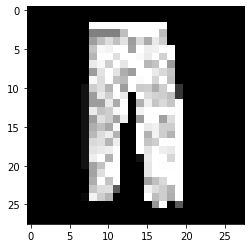

Trouser
[0 0 0 0 0]


In [92]:
import cv2
fashion_mnist_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

image_data =cv2.imread('pants.png', cv2.IMREAD_GRAYSCALE)
image_data = cv2.resize(image_data, (28, 28))
image_data = 255-image_data
import matplotlib.pyplot as plt
plt.imshow(image_data, cmap='gray')
plt.show()

model2 = Model.load("fashion_minst_model.txt")

image_data = (image_data.reshape(1, -1).astype(np.float32)-127.5)/127.5

confidences = model2.predict(image_data)
predictions = model2.output_layer_activation.predictions(confidences)
for prediction in predictions:
    print(fashion_mnist_labels[prediction])
print(y_test[:5])


